In [352]:
import csv
import pandas as pd
import numpy as np
import pickle
import os
import pdb

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchnet
from torch.autograd import Variable


In [373]:
#this section: to gather data from csv

#getting names of data files
debate = 1
#debate = 3

#look at files of candidate we're interested in
detstr = 'HC'
detstr = 'DT'

runtype = '_self'
#runtype = '_nopose'
#runtype = '_cross'
#runtype = '_self_noface'

#runtype = '_nopr'
#runtype = '_noface'

if (detstr == 'DT'):
    candidate = 'trump'
    altcand = 'clinton'
    altstr = 'HC'
else:
    candidate = 'clinton'
    altcand = 'trump'
    altstr = 'DT'

if (runtype == '_self' or runtype == '_self_noface'):
    altstr = detstr
    altcand = candidate

facefile = 'of_results/debate'+str(debate) + '_' + candidate + '_adj3.csv'
facealt = 'of_results/debate'+str(debate) + '_' + altcand + '_adj3.csv'
#posefile = 'op_results/debate'+str(debate) + '_' + candidate + '_features_op_colnames.csv'
posefile = 'op_results/debate'+str(debate) + '_' + candidate + '_adj3.csv'
posefile2 = 'op_results/debate'+str(debate) + '_' + altcand + '_adj3.csv'

#load very large csvs in chunks
chunksize = 1000000

face = pd.read_csv(facefile, chunksize=chunksize, iterator=True)
facedf = pd.concat(face, ignore_index=True)
facedf.columns = facedf.columns.str.strip()
print(len(facedf.columns))

face2 = pd.read_csv(facealt, chunksize=chunksize, iterator=True)
facedfalt = pd.concat(face2, ignore_index=True)
facedfalt.columns = facedfalt.columns.str.strip()

# for some reason a bunch of extra columns would be generated at random intervals, so this just cuts off the
# data frame so that it only uses the ones labeled by openpose.
pose = pd.read_csv(posefile, chunksize=chunksize, iterator=True)
posedf = pd.concat(pose, ignore_index=True)
posedf.columns = posedf.columns.str.strip()
posedf = posedf.reset_index(drop=True)

pose2 = pd.read_csv(posefile2, chunksize=chunksize, iterator=True)
posedf2 = pd.concat(pose2, ignore_index=True)
posedf2.columns = posedf2.columns.str.strip()
posedf2 = posedf2.reset_index(drop=True)


222


In [374]:

class LSTMTagger(nn.Module):

    def __init__(self, input_dim, hidden_dim, tagset_size, is_max_response=False):
        super(LSTMTagger, self).__init__()
        
        self.is_max_response = is_max_response
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim)

        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.hidden = self.init_hidden()

        #self.maxlayer = nn.MaxPool1d(300)

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        
        return ((torch.zeros(1, 1, self.hidden_dim).cuda()),
                (torch.zeros(1, 1, self.hidden_dim).cuda()))

    def forward(self, input):
        #pdb.set_trace()
        #embeds = self.word_embeddings(sentence)

        lstm_out, self.hidden = self.lstm(
            input.view(len(input), 1, -1), self.hidden)
        
        tag_space = self.hidden2tag(lstm_out.view(len(input), -1))
        #print(tag_space.size())
        #print(tag_space)
        
        #pdb.set_trace()
        if self.is_max_response:
            #val, idx = tag_scores.max(0)
            #print(tag_scores.size())
            
            tag_scores = F.log_softmax(tag_space, dim=1)
            
            val, idx = tag_scores.max(0)
            output = val.view(1,2)
            
            #x = tag_scores.transpose(0,1).view(1, 2, len(input))
            #output = self.maxlayer(x)
            #output = output.view(1,2)
            
        else:
            tag_space = tag_space[-1].view(1,2)
            output = F.log_softmax(tag_space, dim=1)
            
        return output
    

In [375]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

candidate = detstr #change to DT if interested in trump
#candidate = 'HC'

#determine which id to check for in file
id = 0
feat_prefix = 'hc_'
alt_prefix = 'dt_'
if (candidate == 'DT'):
    id = 1
    feat_prefix='dt_'
    alt_prefix = 'hc_'
    
#base_pos[(base_pos > 0.01) & (base_pos < 0.99)].index
valid_columns = ['dt_nonflu', 'dt_putdown', 'dt_attone', 'dt_hrtone',
       'dt_lookat2', 'dt_brush1', 'dt_atface', 'dt_hrface', 'dt_neuface',
       'dt_inapprop', 'dt_affgest', 'dt_defgest', 'dt_commun', 'dt_nvtic2',
       'dt_nvtic3', 'dt_6ltr', 'dt_i', 'dt_they', 'dt_interruptions',
       'dt_blame2', 'dt_anger']

dt_valid_columns = ['dt_lookat2', 'dt_brush1', 'dt_nvdis1', 'dt_lookat3',
       'dt_eyebrow', 'dt_atface', 'dt_feface', 'dt_hrface', 'dt_saface',
       'dt_neuface', 'dt_inapprop', 'dt_affgest', 'dt_defgest', 
       'dt_agentic', 'dt_waveoff', 'dt_nvtic1', 'dt_nvtic2',
       'dt_nvtic3', 'dt_nvtic5', 'dt_nvtic6', 
       'dt_interruptions']

hc_valid_columns = ['hc_' + x[3:] for x in dt_valid_columns]
hc_valid_columns[3] = 'hc_look'

#load base data
df_label = pd.read_csv('debate1populism_revised2-last3remove.csv', index_col=0)

#load trump data + variables
trump_labels = [col for col in df_label if col.startswith('dt_') and 'segtype' not in col]
trump_labels = dt_valid_columns

dt_label = df_label[trump_labels]
#dt_label.fillna(0, inplace=True)

#load clinton data + variables
clinton_labels = [col for col in df_label if col.startswith('hc_')  and 'segtype' not in col]
clinton_labels = hc_valid_columns

hc_label = df_label[clinton_labels]
#hc_label.fillna(0, inplace=True)

#randomly split features and labels into train/test set
currlabel = []
if (candidate == 'HC'):
    currlabel = hc_label
    altlabel = dt_label
    
elif (candidate == 'DT'):
    currlabel = dt_label
    altlabel = hc_label
    
currlabel.rename(columns={feat_prefix+'nvtic6': feat_prefix+'nvtic4'}, inplace=True)
altlabel.rename(columns={alt_prefix+'nvtic6': alt_prefix+'nvtic4'}, inplace=True)
print(currlabel.columns)
print(altlabel.columns)

Index(['dt_lookat2', 'dt_brush1', 'dt_nvdis1', 'dt_lookat3', 'dt_eyebrow',
       'dt_atface', 'dt_feface', 'dt_hrface', 'dt_saface', 'dt_neuface',
       'dt_inapprop', 'dt_affgest', 'dt_defgest', 'dt_agentic', 'dt_waveoff',
       'dt_nvtic1', 'dt_nvtic2', 'dt_nvtic3', 'dt_nvtic5', 'dt_nvtic4',
       'dt_interruptions'],
      dtype='object')
Index(['hc_lookat2', 'hc_brush1', 'hc_nvdis1', 'hc_look', 'hc_eyebrow',
       'hc_atface', 'hc_feface', 'hc_hrface', 'hc_saface', 'hc_neuface',
       'hc_inapprop', 'hc_affgest', 'hc_defgest', 'hc_agentic', 'hc_waveoff',
       'hc_nvtic1', 'hc_nvtic2', 'hc_nvtic3', 'hc_nvtic5', 'hc_nvtic4',
       'hc_interruptions'],
      dtype='object')


/home/cvpc/anaconda3/envs/pytorch/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [376]:
# prepare data structures for use in classification
def split_data(currlabel, cutdf, test_size=0.2, shuffle=True):
    indices = list(currlabel.index)
    #print("Indices: " + str(indices))
    train_nums, test_nums = train_test_split(indices, test_size = test_size, shuffle=shuffle) #8:2 train:test split
    train_nums.sort()
    test_nums.sort()

    v1_train = []
    v1_test = []
    for tr in train_nums:
        v1_train.append(indices.index(tr))
        #print("indices.index(tr): " + str(indices.index(tr)))
    for te in test_nums:
        v1_test.append(indices.index(te))
        #print("indices.index(te): " + str(indices.index(tr)))


    train_labels = currlabel.iloc[v1_train]
    test_labels = currlabel.iloc[v1_test]

    train_labels = train_labels.copy()
    train_labels[train_labels != 0] = 1

    test_labels = test_labels.copy()
    test_labels[test_labels != 0] = 1

    df = cutdf[cutdf.face_id == 0]
    #val_featcol = [x for x in df.columns if 'AU' in x or 'gaze' in x or 'pose' in x or 'timestamp' in x]
    #val_featcol = [x for x in df.columns if 'AU' in x or 'gaze' in x or 'timestamp' in x]
    val_featcol = [x for x in df.columns if 'AU' in x or 'gaze' in x or 'p_' in x or 'timestamp' in x]
    #val_featcol = [x for x in df.columns if 'x_' in x or 'y_' in x or 'timestamp' in x]
    
    df = df[val_featcol]
    
    #featdims = len(val_featcol) - 1
    #print(featdims)
    
    return df, train_labels, test_labels



In [377]:
# prepare data structures for use in classification
def split_data11(currlabel, cutdf, altlabel, compdf, test_size=0.2, shuffle=True):
    indices = list(currlabel.index)
    compindices = list(altlabel.index)
    #print("Indices: " + str(indices))
    train_nums, test_nums0 = train_test_split(indices, test_size = test_size, shuffle=shuffle) #8:2 train:test split
    train_nums0, test_nums = train_test_split(compindices, test_size = test_size, shuffle=shuffle) #8:2 train:test split
    train_nums.sort()
    test_nums.sort()

    v1_train = []
    v1_test = []
    for tr in train_nums:
        v1_train.append(indices.index(tr))
        #print("indices.index(tr): " + str(indices.index(tr)))
    for te in test_nums:
        v1_test.append(compindices.index(te))
        #print("indices.index(te): " + str(indices.index(tr)))


    train_labels = currlabel.iloc[v1_train]
    test_labels = altlabel.iloc[v1_test]

    train_labels = train_labels.copy()
    train_labels[train_labels != 0] = 1

    test_labels = test_labels.copy()
    test_labels[test_labels != 0] = 1

    df = cutdf[cutdf.face_id == 0]
    testdf = compdf[compdf.face_id == 0]
    #val_featcol = [x for x in df.columns if 'AU' in x or 'gaze' in x or 'pose' in x or 'timestamp' in x]
    #val_featcol = [x for x in df.columns if 'AU' in x or 'gaze' in x or 'timestamp' in x]
    val_featcol = [x for x in df.columns if 'AU' in x or 'gaze' in x or 'p_' in x or 'timestamp' in x]

    
    if (runtype == '_nopr'):
        val_featcol = [x for x in df.columns if ('AU' in x or 'gaze' in x or 'p_' in x or 'timestamp' in x) and ('p_r' not in x)]
        val_featcol2 = [x for x in testdf.columns if ('AU' in x or 'gaze' in x or 'p_' in x or 'timestamp' in x) and ('p_r' not in x)]
    else:
        val_featcol = [x for x in df.columns if 'AU' in x or 'gaze' in x or 'p_' in x or 'timestamp' in x]
        val_featcol2 = [x for x in testdf.columns if 'AU' in x or 'gaze' in x or 'p_' in x or 'timestamp' in x]
        
        val_featcol = [x for x in df.columns if 'x_' in x or 'y_' in x or 'timestamp' in x]
        val_featcol2 = [x for x in testdf.columns if 'x_' in x or 'y_' in x or 'timestamp' in x]
        
    #val_featcol = [x for x in df.columns if 'AU' in x or 'y_' in x or 'x_' in x or 'timestamp' in x]

    df = df[val_featcol]
    testdf = testdf[val_featcol2]
    
    #print(df)
    
    #featdims = len(val_featcol) - 1
    #print(featdims)
    
    return df, testdf, train_labels, test_labels



In [378]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def save_roc(col, target_scores, prediction_scores):
    fpr, tpr, thresholds = roc_curve(y_true = np.array(target_scores), y_score = np.array(prediction_scores))
    roc_auc = auc(fpr, tpr)

    fig = plt.figure()
    plt.plot(fpr, tpr, color='red', lw=1, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if col[:2] == 'dt':
        #
        if (runtype != '_self' and runtype != '_self_noface'):
            col = 'Clinton ' + col[3:]
        else:
            col = 'Trump ' + col[3:]
    else:
        #
        if (runtype != '_self' and runtype != '_self_noface'):
            col = 'Trump ' + col[3:]
        else:
            col = 'Clinton ' + col[3:] 
        
    plt.title(col)
    plt.legend(loc="lower right")
    plt.show()
    try:
        os.makedirs(('visualsjs/modelres/' + detstr + '_' + str(debate) + '-' + altstr + '_' + str(debate) + runtype))
    except:
        print("Directory already exists!")
    fig.savefig('visualsjs/modelres/' + detstr + '_' + str(debate) + '-' + altstr + '_' + str(debate) + runtype + '/ROC_'+col + '.png', dpi = 300)
    
    return roc_auc


In [379]:
init_time = 0

AUC_repeat = pd.DataFrame(columns = currlabel.columns)
corr_repeat = pd.DataFrame(columns = currlabel.columns)
n_repeat = 5
n_epoch = 2
#featdims = 83 + 50
#featdims = 137 + 16
#featdims = 175 + 52
if (runtype == '_nopr'):
    featdims = 130
else:
    featdims = 133
    
#featdims = 186

pose_feat_coeff = 1
face_feat_coeff = 1
#face_feat_coeff=0
if (runtype == '_nopose'):
    pose_feat_coeff = 0
elif (runtype == '_noface' or runtype == '_self_noface'):
    face_feat_coeff=0

#pose_feat_coeff = 100

run_name = 'face_pose'
pose_feat_coeff = 0

if (runtype == '_self' or runtype == '_self_noface'):
    posedf2 = posedf

for r in range(n_repeat):
    #df, train_labels, test_labels = split_data(currlabel, facedf, 0.2, True)
    #df, testdf, train_labels, test_labels = split_data33(currlabel, facedf, altlabel, facedfalt, 0.2, True)
    if (runtype == '_self' or runtype == '_self_noface'):
        df, train_labels, test_labels = split_data(currlabel, facedf, 0.2, True)
        testdf = df
    else:
        df, testdf, train_labels, test_labels = split_data11(currlabel, facedf, altlabel, facedfalt, 0.2, True)
    ndim_out = len(currlabel.columns)
    #eval_metric = pd.DataFrame(columns = train_labels.columns)

    #eval_metric = pd.DataFrame(columns = ['train_AP_pos', 'train_AP_neg', 'train_base_pos', 'AP_pos', 'AP_neg', 'base_pos'])
    eval_metric = pd.DataFrame(index = train_labels.columns, columns = ['train_AP_neg', 'train_AP_pos', 'train_loss', 'train_base_pos', 'AP_neg', 'AP_pos', 'loss', 'base_pos', 'ROC_AUC', 'corr'])

    #print(eval_metric.loc['dt_atface', 'AP_pos'])

    base_pos = train_labels.sum() / train_labels.shape[0]
    eval_metric['train_base_pos'] = base_pos
    base_pos = test_labels.sum() / test_labels.shape[0]
    eval_metric['base_pos'] = base_pos

    #train_labels = train_labels[['dt_atface']]
    #train_labels = train_labels[['dt_lookat2']]
    
    use_train_labels = train_labels
    #use_train_labels = train_labels[['dt_nvdis1', 'dt_defgest', 'dt_agentic', 'dt_nvtic4']]
    #use_train_labels = train_labels[['hc_atface']]
    
    for i, col in enumerate(use_train_labels.columns):
        model = LSTMTagger(input_dim=featdims, hidden_dim=256, tagset_size=2, is_max_response=False)
        #model = LSTMTagger(input_dim=featdims, hidden_dim=32, tagset_size=2, is_max_response=False)
        model.cuda()

        loss_function = nn.NLLLoss()
        loss_function.cuda()

        optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005)

        for epoch in range(n_epoch):  
            datalist = train_labels.index.values.copy()
            datalist = np.random.permutation(datalist)

            ap = torchnet.meter.APMeter()
            model.train()

            prediction_scores = []
            target_scores = []
            
            lossval = np.array([])
            
            for tid in datalist:
                model.zero_grad()
                model.hidden = model.init_hidden()
                
                time0 = init_time + (tid-1) * 10
                time1 = time0 + 10
                #print("[TRAIN; TID" + str(tid) + "] TIME0: " + str(time0) + " | TIME1: " + str(time1))

                feature = df[(df.loc[:, 'timestamp'] >= time0) & (df.loc[:, 'timestamp'] < time1)]
                feature = feature.iloc[:, 1:] * face_feat_coeff

                # add OpenPose feature
                x = posedf[posedf.iloc[:,0] >= time0 * 30]
                if (x.size < 1):
                    continue
                x = posedf.iloc[x.index[0]:x.index[0]+feature.shape[0], 1:] * pose_feat_coeff
                #x.loc[:, 'x_2':] = 0

                feature.reset_index(drop=True, inplace=True)
                x.reset_index(drop=True, inplace=True)
                feature = pd.concat( [feature, x], axis=1) 

                #print("[TRAIN] Features size: " + str(feature.size))
                #print("[TRAIN] FEATURE NANS ON TID " + str(tid) + ": " + str((np.isnan(feature).sum().sum())))
                feature.dropna(inplace=True)
                #print("[TRAIN] NANS AFTER DROPNA ON TID " + str(tid) + ": " + str((np.isnan(feature).sum().sum())))
                feature = torch.tensor(feature.values, dtype=torch.float)
                #print (feature)
                feature = feature.cuda()
                #print("FEATURE ON TID " + str(tid))
                #print(feature)

                #subcol = col.split('_').str[1]

                #print(subcol)
                targets = train_labels.loc[tid, col]
                #print("[TRAIN] TARGETS ")
                #print(targets)
                #print(tid)
                targets = torch.tensor([[targets]], dtype=torch.long)
                target_vec = np.zeros([1, 2])
                target_vec[0, targets[0][0]] = 1

                targets = targets.cuda()

                # Step 3. Run our forward pass.
                #print("Feature: ")
                scores = model(feature)
                #print("Scores (TRAIN): ")
                #print(scores)

                scores_ap = scores.data.clone()
                ap.add(scores_ap, target_vec)

                prediction_scores.append(scores_ap[0][1].item())
                target_scores.append(targets.item())
                
                loss = loss_function(scores, targets[0])
                lossval = np.append(lossval, loss.data.cpu())

                loss.backward()
                optimizer.step()
                if tid % 200 == 0:
                    #print("TID % 200:")
                    print(col +" " + str(epoch) + " ap " + str(ap.value()) + " loss : " + str(loss.data.item()) + " " + str(lossval.mean()) + " tid : " + str(tid) + " tg " + str(targets))

            #print(ap.value())
            eval_metric.iloc[i, 0:3] = ap.value().tolist() + [loss.data.item()]
            #print(eval_metric)

            #roc_auc = save_roc(col, target_scores[:-1], prediction_scores[:-1])

            datalist = test_labels.index.values.copy()
            #datalist = np.random.permutation(datalist)

            ntest = datalist.size
            prediction_scores = []
            target_scores = []

            lossval = np.array([])
            ap = torchnet.meter.APMeter()
            model.eval()

            for tid in datalist:
                #try:
                model.zero_grad()
                model.hidden = model.init_hidden()

                time0 = init_time + (tid-1) * 10
                time1 = time0 + 10

                feature = testdf[(testdf.loc[:, 'timestamp'] >= time0) & (testdf.loc[:, 'timestamp'] < time1)]
                feature = feature.iloc[:, 1:] * face_feat_coeff

                # add OpenPose feature
                x = posedf2[posedf2.iloc[:,0] >= time0 * 30]
                if (x.size < 1):
                    continue
                    
                x = posedf2.iloc[x.index[0]:x.index[0]+feature.shape[0], 1:] * pose_feat_coeff
                #x.loc[:, 'x_2':] = 0

                
                feature.reset_index(drop=True, inplace=True)
                x.reset_index(drop=True, inplace=True)
                feature = pd.concat( [feature, x], axis=1)
                feature.dropna(inplace=True)
                #print("[TEST] Features size: " + str(feature.size))
                #print("[TEST] FEATURE NANS ON TID " + str(tid) + ": " + str((np.isnan(feature).sum().sum())))

                #feature.values
                feature = torch.tensor(feature.values, dtype=torch.float)
                feature = feature.cuda()
                #feature = Variable(feature)
                
                subcol = col.split('_')[1]
                #rightc = [c for c in altlabel.columns if subcol in c]
                
                if (subcol == 'look' and runtype != '_self' and runtype != '_self_noface'):
                    rightc = 'lookat3'
                    rightc = altstr.lower() + '_' + rightc
                elif (subcol == 'lookat3' and runtype != '_self' and runtype != '_self_noface'):
                    rightc = 'look'
                    rightc = altstr.lower() + '_' + rightc
                else:
                    rightc = altstr.lower() + '_' + subcol
                #print(rightc)
                #print(subcol)
                #targets = test_labels.loc[tid, col]
                targets = test_labels.loc[tid, rightc]
                #targets = test_labels.loc[tid, rightc[0]]
                
                #print("[TRAIN] TARGETS ")
                #print(targets)
                #print(tid)
                #targets = test_labels.loc[tid, col]
                #print(str(targets))
                targets = torch.tensor([[targets]], dtype=torch.long)
                target_vec = np.zeros([1, 2])
                target_vec[0, targets[0][0]] = 1
                targets = targets.cuda()

                # Step 3. Run our forward pass.
                scores = model(feature)
                #print("SCORES: ")
                #print(scores)

                scores_ap = scores.data.clone()
                ap.add(scores_ap, target_vec)

                prediction_scores.append(scores_ap[0][1].item())
                target_scores.append(targets.item())

                loss = loss_function(scores, targets[0])
                lossval = np.append(lossval, loss.data.cpu())

                if tid % 30 == 0:
                    print("TEST " + col +" " + str(epoch) + " ap " + str(ap.value()) + " loss : " + str(loss.data.item()) + " " + str(lossval.mean()) + " tid : " + str(tid) + " tg " + str(targets))
                #except:
                    #print("AT END OF FILE (TEST)")
                    #continue
            eval_metric.iloc[i, 4:7] = ap.value().tolist() + [loss.data.item()]
            
            #print("col:")
            #print(col)
            #print("target_scores:")
            #print(target_scores)
            #print("prediction scores: ")
            #print(prediction_scores)
            
            #del prediction_scores[-1]
            #del target_scores[-1]
            
            roc_auc = save_roc(col, target_scores[:-1], prediction_scores[:-1])
            eval_metric.loc[col, 'ROC_AUC'] = roc_auc
            eval_metric.loc[col, 'corr'] = np.corrcoef(prediction_scores, target_scores)[0][1]
            eval_metric.to_csv('visualsjs/modelres/' + detstr + '_' + str(debate) + '-' + altstr + '_' + str(debate) + runtype + '/result_' + detstr + '_' + str(r) + '.csv')

    AUC_repeat = AUC_repeat.append(eval_metric['ROC_AUC'])
    corr_repeat = corr_repeat.append(eval_metric['corr'])
    
    #print(AUC_repeat.mean())
    #print(AUC_repeat.std())
    #print(eval_metric)

AUC_repeat = AUC_repeat.set_index([list(range(n_repeat))])
corr_repeat = corr_repeat.set_index([list(range(n_repeat))])
    
for M, f in [[AUC_repeat, 'auc'], [corr_repeat, 'corr']]:
    x = M.mean()
    x.name = 'mean'
    M = M.append(x)

    x = AUC_repeat.std()
    x.name = 'std'
    M = M.append(x)

    M.to_csv('visualsjs/modelres/' + detstr + '_' + str(debate) + '-' + altstr + '_' + str(debate) + runtype + '/' + candidate + '_' + f + '_multi_' + run_name + '.csv')

dt_lookat2 0 ap tensor([ 0.7928,  0.8535]) loss : 0.8060346841812134 0.595802531838417 tid : 200 tg tensor([[ 1]], device='cuda:0')


KeyboardInterrupt: 

([<matplotlib.axis.XTick at 0x7f0d5c1b8f28>,
 <a list of 107 Text xticklabel objects>)

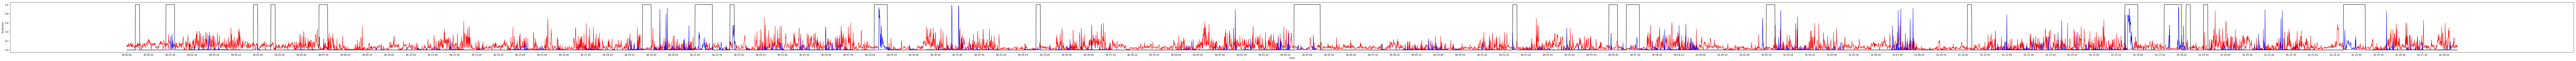

In [343]:
def hhmmss(seconds):
    """Convert seconds to a time string "[[[DD:]HH:]MM:]SS".
    """
    dhms = ''
    hh = seconds//3600
    seconds = seconds - hh * 3600
    mm = seconds//60
    ss = seconds - mm * 60
    dhms = '{0:02d}:{1:02d}:{2:02d}'.format(hh,mm,ss)
    return dhms


anno = df_label['dt_hrface']


plt.figure(figsize=(200,4))
#plt.plot(t, (y - ymax), linewidth=2, label='Prediction')
#plt.plot(t, np.array(target_scores), linewidth=2, label='Annotation')
#plt.ylim(-.1, 1.1)
plt.xlabel('Time');
plt.ylabel('Prediction');
#plt.title('Trump Lookat');


t = np.linspace(0, 10660/2, num=10661)
tm = [hhmmss(int(x)) for x in t]

annoy = np.zeros(t.size)
c = 0
for x in anno:
    for i in range(20):
        annoy[c] = x
        c = c + 1

plt.plot(t, faceex['angry'].rolling(window=1).mean(), 'r')
plt.plot(t, faceex['happy'].rolling(window=1).mean(), 'b')
plt.plot(t, annoy, 'k')

plt.xticks(t[0::100], tm[0::100])
#plt.xlim(3200, 6200)

In [339]:
annoy[0]

IndexError: too many indices for array

13


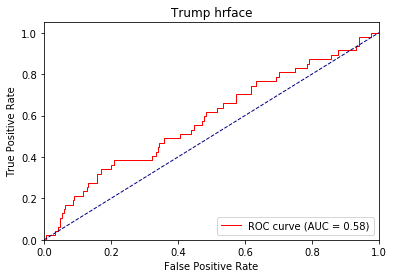

Directory already exists!


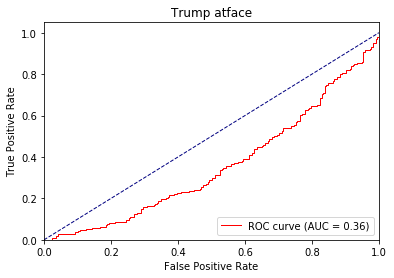

Directory already exists!


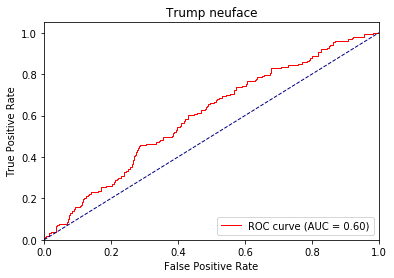

Directory already exists!


,train_AP_neg,train_AP_pos,train_loss,train_base_pos,AP_neg,AP_pos,loss,base_pos,ROC_AUC,corr
dt_lookat2,NaN,NaN,NaN,0.6,0.901291,0.106757,0.340546,0.640000,NaN,NaN
dt_brush1,NaN,NaN,NaN,0.2,0.438623,0.579909,1.24265,0.081905,NaN,NaN
dt_nvdis1,NaN,NaN,NaN,0.8,0.687937,0.327094,0.340546,0.704762,NaN,NaN
dt_lookat3,NaN,NaN,NaN,0.8,NaN,NaN,NaN,0.800000,NaN,NaN
dt_eyebrow,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.912381,NaN,NaN
dt_atface,NaN,NaN,NaN,0.6,NaN,NaN,NaN,0.584762,0.360513,-0.246167
dt_feface,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000000,NaN,NaN
dt_hrface,NaN,NaN,NaN,0.2,NaN,NaN,NaN,0.087619,0.584415,0.0903933
dt_saface,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000000,NaN,NaN
dt_neuface,NaN,NaN,NaN,0.2,NaN,NaN,NaN,0.293333,0.600056,0.157608


In [389]:
chunksize = 1000000

fn = 'clinton_full.csv'
fn = 'trump_full.csv'

xx = pd.read_csv(fn, chunksize=chunksize, iterator=True)
faceex = pd.concat(xx, ignore_index=True)
faceex.columns = faceex.columns.str.strip()
print(len(faceex.columns))

faceex.index
faceex.shape[0]
n = faceex.shape[0]

faceex['time'] = np.linspace(0, n-1, num=n)/2


#eval_metric = pd.DataFrame(columns = ['train_AP_pos', 'train_AP_neg', 'train_base_pos', 'AP_pos', 'AP_neg', 'base_pos'])
eval_metric = pd.DataFrame(index = train_labels.columns, columns = ['train_AP_neg', 'train_AP_pos', 'train_loss', 'train_base_pos', 'AP_neg', 'AP_pos', 'loss', 'base_pos', 'ROC_AUC', 'corr'])
#print(eval_metric.loc['dt_atface', 'AP_pos'])

base_pos = train_labels.sum() / train_labels.shape[0]
eval_metric['train_base_pos'] = base_pos
base_pos = test_labels.sum() / test_labels.shape[0]
eval_metric['base_pos'] = base_pos

use_train_labels = train_labels
#use_train_labels = train_labels[['dt_nvdis1', 'dt_defgest', 'dt_agentic', 'dt_nvtic4']]
#use_train_labels = train_labels[['hc_atface']]
#use_train_labels = train_labels[['hc_saface', 'hc_hrface', 'hc_atface', 'hc_neuface']]

use_train_labels = train_labels[['dt_hrface', 'dt_atface', 'dt_neuface']]


for i, col in enumerate(use_train_labels.columns):
    if (runtype == '_self' or runtype == '_self_noface'):
        df, train_labels, test_labels = split_data(currlabel, facedf, 0.99, True)
        testdf = df
    else:
        df, testdf, train_labels, test_labels = split_data11(currlabel, facedf, altlabel, facedfalt, 0.99, True)
    ndim_out = len(currlabel.columns)
    #eval_metric = pd.DataFrame(columns = train_labels.columns)
    
    datalist = train_labels.index.values.copy()
    datalist = np.random.permutation(datalist)

    ap = torchnet.meter.APMeter()
    model.train()

    prediction_scores = []
    target_scores = []

    lossval = np.array([])

    #roc_auc = save_roc(col, target_scores[:-1], prediction_scores[:-1])

    datalist = test_labels.index.values.copy()
    #datalist = np.concatenate((datalist, train_labels.index.values.copy()))

    #print(datalist)

    ntest = datalist.size
    prediction_scores = []
    target_scores = []

    lossval = np.array([])
    ap = torchnet.meter.APMeter()

    for tid in datalist:

        time0 = init_time + (tid-1) * 10
        time1 = time0 + 10

        feature = faceex[(faceex.loc[:, 'time'] >= time0) & (faceex.loc[:, 'time'] < time1)]
        feature = feature['neutral'].mean()
        
        subcol = col.split('_')[1]
        #rightc = [c for c in altlabel.columns if subcol in c]

        if (subcol == 'look' and runtype != '_self' and runtype != '_self_noface'):
            rightc = 'lookat3'
            rightc = altstr.lower() + '_' + rightc
        elif (subcol == 'lookat3' and runtype != '_self' and runtype != '_self_noface'):
            rightc = 'look'
            rightc = altstr.lower() + '_' + rightc
        else:
            rightc = altstr.lower() + '_' + subcol
        #print(rightc)
        #print(subcol)
        #targets = test_labels.loc[tid, col]
        targets = test_labels.loc[tid, rightc]
        #targets = test_labels.loc[tid, rightc[0]]

        targets = torch.tensor([[targets]], dtype=torch.long)
        target_vec = np.zeros([1, 2])
        target_vec[0, targets[0][0]] = 1
        targets = targets.cuda()


        output = feature
        
        scores_ap = scores.data.clone()
        ap.add(scores_ap, target_vec)

        prediction_scores.append(output)
        target_scores.append(targets.item())

        loss = loss_function(scores, targets[0])
        lossval = np.append(lossval, loss.data.cpu())

    eval_metric.iloc[i, 4:7] = ap.value().tolist() + [loss.data.item()]

    roc_auc = save_roc(col, target_scores[:-1], prediction_scores[:-1])
    eval_metric.loc[col, 'ROC_AUC'] = roc_auc
    eval_metric.loc[col, 'corr'] = np.corrcoef(prediction_scores, target_scores)[0][1]
    eval_metric.to_csv('visualsjs/modelres/' + detstr + '_' + str(debate) + '-' + altstr + '_' + str(debate) + runtype + '/result_' + detstr + '_' + str(r) + '.csv')

eval_metric

In [ ]:
col = 'dt_lookat2'

prediction_scores = []
target_scores = []
timestamps = []

model.eval()
t_max = 530

currlabel[col]

for i,tid in enumerate(np.linspace(1,t_max,(t_max-1)*5+1).tolist()):
    model.zero_grad()

    model.hidden = model.init_hidden()

    time0 = init_time + (tid-1) * 10
    time1 = time0 + 10

    feature = df[(df.loc[:, 'timestamp'] >= time0) & (df.loc[:, 'timestamp'] < time1)]
    feature = feature.iloc[:, 1:]    

    feature = torch.tensor(feature.values, dtype=torch.float)
    feature = feature.cuda()

    scores = model(feature)

    scores_ap = scores.data.clone()

    prediction_scores.append(scores_ap[0][1].item())
    timestamps.append(time1)

    t0int = int(tid+0.9999999)
    val = 1 if currlabel.loc[t0int, col] == 1 else 0
    
    target_scores.append(val)
    if i % 1000 == 0:
        print(i)
    

    

In [ ]:

base_pos = train_labels.sum() / train_labels.shape[0]
eval_metric['train_base_pos'] = base_pos

print(base_pos[(base_pos > 0.01) & (base_pos < 0.99)].index)
valid_columns = ['dt_funct', 'dt_interpt', 'dt_success', 'dt_intype', 'dt_intmod',
       'dt_nonflu', 'dt_putdown', 'dt_attone', 'dt_fetone', 'dt_hrtone',
       'dt_lookat2', 'dt_brush1', 'dt_atface', 'dt_hrface', 'dt_neuface',
       'dt_inapprop', 'dt_affgest', 'dt_defgest', 'dt_commun', 'dt_nvtic2',
       'dt_nvtic3', 'dt_6ltr', 'dt_i', 'dt_they', 'dt_interruptions',
       'dt_blame2', 'dt_anger']

#valid_columms



In [ ]:
def hhmmss(seconds):
    """Convert seconds to a time string "[[[DD:]HH:]MM:]SS".
    """
    dhms = ''
    hh = seconds//3600
    seconds = seconds - hh * 3600
    mm = seconds//60
    ss = seconds - mm * 60
    dhms = '{0:02d}:{1:02d}:{2:02d}'.format(hh,mm,ss)
    return dhms

tm = [hhmmss(int(x)) for x in timestamps]

t = np.array(timestamps)
t = t 
y = np.array(prediction_scores)
y = np.exp(y)
ymax = y.max()
ymax = 0

plt.figure(figsize=(20,8))
plt.plot(t, (y - ymax), label='Prediction')
plt.plot(t, np.array(target_scores), label='Annotation')

plt.xticks(t[0::30], tm[0::30])

plt.ylim(-.1, 1.1)
plt.xlim( 4980, 5280+300)
plt.xlabel('Time');
plt.ylabel('Prediction');
plt.title('Trump Lookat');
#plt.xticks(t[4381:4381+300:40], tm[4381:4381+300:40])
#plt.xticks(t[4081:4381+300:40], tm[4081:4381+300:40])
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

use_train_labels = train_labels[['hc_saface', 'hc_hrface', 'hc_atface', 'hc_neuface']]


#plt.xticks(t[4381:4381+300:40], tm[4381:4381+300:40])
#plt.xticks(t[4081:4381+300:40], tm[4081:4381+300:40])
plt.grid(True)
plt.legend(loc="lower right")
plt.show()





In [ ]:
#df_label.corr().to_csv('corr.csv')
#AUC_repeat.to_csv(candidate + '_auc_multi.csv')

#AUC_repeat = AUC_repeat.set_index([list(range(n_repeat))])

#AUC_repeat = AUC_repeat.set_index([list(range(n_repeat))])
#AUC_repeat.append(AUC_repeat.mean())
#AUC_repeat.append(AUC_repeat.std())

AUC_repeat.to_csv(candidate + '_auc_multi.csv')
x = AUC_repeat.mean()
x.name = 'mean'
AUC_repeat = AUC_repeat.append(x)

x = AUC_repeat.std()
x.name = 'std'
AUC_repeat = AUC_repeat.append(x)

AUC_repeat


In [287]:
eval_metric

,train_AP_neg,train_AP_pos,train_loss,train_base_pos,AP_neg,AP_pos,loss,base_pos,ROC_AUC,corr
hc_lookat2,NaN,NaN,NaN,0.4,0.982479,0.0239328,0.242932,0.512381,NaN,NaN
hc_brush1,NaN,NaN,NaN,0.0,0.533522,0.496103,1.53398,0.127619,NaN,NaN
hc_nvdis1,NaN,NaN,NaN,0.2,0.849572,0.169949,0.242932,0.095238,NaN,NaN
hc_look,NaN,NaN,NaN,0.8,0.655969,0.360182,0.242932,0.676190,NaN,NaN
hc_eyebrow,NaN,NaN,NaN,0.6,NaN,NaN,NaN,0.323810,NaN,NaN
hc_atface,NaN,NaN,NaN,0.2,NaN,NaN,NaN,0.129524,0.776875,0.309395
hc_feface,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000000,NaN,NaN
hc_hrface,NaN,NaN,NaN,0.2,NaN,NaN,NaN,0.508571,0.113782,-0.652763
hc_saface,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.017143,0.845523,0.145846
hc_neuface,NaN,NaN,NaN,0.6,NaN,NaN,NaN,0.342857,0.764767,0.433514


In [ ]:
def hhmmss(seconds):
    """Convert seconds to a time string "[[[DD:]HH:]MM:]SS".
    """
    dhms = ''
    hh = seconds//3600
    seconds = seconds - hh * 3600
    mm = seconds//60
    ss = seconds - mm * 60
    dhms = '{0:02d}:{1:02d}:{2:02d}'.format(hh,mm,ss)
    return dhms

tm = [hhmmss(int(x)) for x in timestamps]
tm

In [160]:
ind = np.argsort(gradxy)[::-1]
#ind
print(gradxy[ind] * 1000)
print(ind)

[76.24435425 51.51891708 40.07065296 39.98196125 36.93270683 36.48471832
 35.93361378 35.83562374 34.10840034 33.28049183 32.25493431 29.83748913
 29.24227715 27.55177021 27.48405933 27.1602869  27.09937096 26.69894695
 24.42145348 23.92816544 23.57077599 22.40800858 22.09365368 21.84641361
 21.10886574 20.32935619 20.17068863 19.81377602 19.51086521 19.41227913
 19.01996136 18.7869072  18.43070984 18.11504364 18.01800728 18.0028677
 17.56417751 17.51852036 17.38035679 16.89708233 16.75450802 16.47651196
 16.23606682 16.06571674 15.69628716 15.4311657  15.40911198 15.34879208
 15.2579546  15.14053345 14.8203373  14.32681084 14.10830021 13.94867897
 13.66281509 13.51690292 13.0764246  12.89713383 11.84391975 11.739254
 11.69753075 10.78033447 10.3751421  10.36918163 10.19906998 10.12504101
  9.75632668  8.18812847]
[38 44 37 66 46  1 39 54 43 45 62  7 67 57 26 17 27 36  8  2 56 50  0 28
  6 47 21 34 20 59 42 12 31 52  3 49 33  5 10 61 58 64 63 65 11 32 35 40
 29 22 30 15 18 24  4 16 25 

In [219]:
chunksize = 1000000
fn = 'of_results/debate1_trump_features_of.csv'

fn = 'of_results/debate1_clinton_features_of.csv'

faceorg = pd.read_csv(fn, chunksize=chunksize, iterator=True)
facedforg = pd.concat(faceorg, ignore_index=True)
facedforg.columns = facedforg.columns.str.strip()
print(len(facedf.columns))

hc_facedforg = facedforg

222


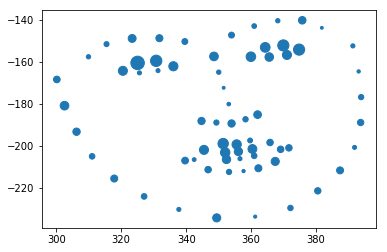

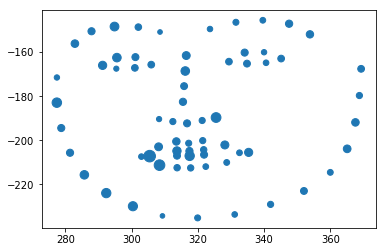

In [240]:
#xmean = 352.2170271121847
#facedforginv = facedforg.copy()
#facedforginv.loc[:,'x_0':'x_67'] *= -1

#FF = pd.concat([facedforg, facedforginv])

FF = dt_facedforg

xx = FF.loc[:,'x_0':'x_67'].mean().values
yy = -FF.loc[:,'y_0':'y_67'].mean().values

import matplotlib.pyplot as plt

area = np.ones(68)
area = (dt_gradxy_at)*22000

plt.scatter(xx, yy, s=area)
plt.show()




FF = hc_facedforg

xx = FF.loc[:,'x_0':'x_67'].mean().values
yy = -FF.loc[:,'y_0':'y_67'].mean().values

import matplotlib.pyplot as plt

area = np.ones(68)
area = (gradxy)*15000

plt.scatter(xx, yy, s=area)
plt.show()


In [218]:
dt_gradxy_at = gradxy_at
dt_facedforg = facedforg

In [143]:
#for i in range(132):

def gradrnn(feature, model):
    outorg = model(feature)

    grad = np.zeros(136)
    gradxy = np.zeros(68)

    for i in range(136):
        model.zero_grad()
        model.hidden = model.init_hidden()
        f = feature.clone()

        #print(f[:, 0])
        f[:, i] += 0.01
        #print(f[:, 0])

        out = model(f)

        #print(out)
        #print(abs(out - outorg).cpu().data.numpy()[0,0])
        grad[i] = abs(out - outorg).cpu().data.numpy()[0,0]

    for i in range(68):
        #gradxy[i] = np.sqrt(grad[i*2+1]**2)
        gradxy[i] = np.sqrt(grad[i*2]**2 + grad[i*2+1]**2)
    
    return gradxy


In [235]:
model.eval()
gradxy = np.zeros(68)

for tid in datalist:
    time0 = init_time + (tid-1) * 10
    time1 = time0 + 10

    feature = testdf[(testdf.loc[:, 'timestamp'] >= time0) & (testdf.loc[:, 'timestamp'] < time1)]
    feature = feature.iloc[:, 1:] * face_feat_coeff

    # add OpenPose feature
    x = posedf2[posedf2.iloc[:,0] >= time0 * 30]
    if (x.size < 1):
        continue

    x = posedf2.iloc[x.index[0]:x.index[0]+feature.shape[0], 1:] * pose_feat_coeff

    feature.reset_index(drop=True, inplace=True)
    x.reset_index(drop=True, inplace=True)
    feature = pd.concat( [feature, x], axis=1)
    feature.dropna(inplace=True)

    feature = torch.tensor(feature.values, dtype=torch.float)
    feature = feature.cuda()

    o = gradrnn(feature, model)
    gradxy = gradxy + o
    
    if tid % 20 == 0:
        print (tid)

    

20
240
300


In [ ]:
(cutdf['frame'].iloc[-1] - cutdf['frame'].iloc[0]) * 2

In [184]:
datalist

array([  3,  19,  20,  24,  27,  33,  36,  40,  47,  48,  53,  54,  56,
        57,  59,  61,  64,  65,  67,  69,  73,  74,  90,  92,  93, 101,
       102, 110, 111, 112, 132, 133, 136, 137, 139, 145, 147, 152, 156,
       166, 174, 178, 186, 190, 205, 206, 207, 209, 211, 215, 220, 224,
       226, 239, 241, 245, 250, 251, 259, 263, 264, 267, 271, 283, 294,
       322, 323, 328, 339, 344, 349, 353, 379, 383, 389, 391, 392, 398,
       406, 412, 417, 419, 420, 423, 444, 446, 450, 452, 453, 455, 456,
       466, 470, 476, 481, 491, 496, 497, 499, 502, 513, 523, 524, 525,
       527, 530])

In [ ]:
import torchnet

In [ ]:
cutdf.columns

In [ ]:
df.rename(columns={' timestamp': 'timestamp'}, inplace=True)


In [ ]:
cutdf.columns

In [ ]:
df0 = cutdf[cutdf.face_id == 0]
df1 = cutdf[cutdf.face_id == 1]
df2 = cutdf[cutdf.face_id == 2]

In [ ]:

print( df0.loc[:, ['face_id', ' x_0', ' confidence', 'pose_Tx', ' pose_Ty']].mean() )
print( df0.loc[:, ['face_id', ' x_0', ' confidence', 'pose_Tx', ' pose_Ty']].min() )
print( df0.loc[:, ['face_id', ' x_0', ' confidence', 'pose_Tx', ' pose_Ty']].max() )

print( df1.loc[:, ['face_id', ' x_0', ' confidence', 'pose_Tx', ' pose_Ty']].mean() )
print( df1.loc[:, ['face_id', ' x_0', ' confidence', 'pose_Tx', ' pose_Ty']].min() )
print( df1.loc[:, ['face_id', ' x_0', ' confidence', 'pose_Tx', ' pose_Ty']].max() )

print( df2.loc[:, ['face_id', ' x_0', ' confidence', 'pose_Tx', ' pose_Ty']].mean() )
print( df2.loc[:, ['face_id', ' x_0', ' confidence', 'pose_Tx', ' pose_Ty']].min() )
print( df2.loc[:, ['face_id', ' x_0', ' confidence', 'pose_Tx', ' pose_Ty']].max() )



In [ ]:
train_labels.columns

In [ ]:
cutdf[cutdf.frame == 174866][[' timestamp', ' X_0', ' Y_0']]

In [ ]:
df0['frame'].iloc[-1] - df0['frame'].iloc[0]

In [ ]:
df0.shape

In [ ]:
26618 in df0['frame']

In [ ]:
training_data

In [ ]:
df.loc[13438, ['face_id']]

In [ ]:
df.timestamp

In [ ]:
tid = 1
col = 'dt_attone'

# Step 1. Remember that Pytorch accumulates gradients.
# We need to clear them out before each instance
model.zero_grad()

# Also, we need to clear out the hidden state of the LSTM,
# detaching it from its history on the last instance.
model.hidden = model.init_hidden()

print(tid)
print(col)

time0 = init_time + (tid-1) * 10
time1 = time0 + 10

print (time0, time1)


feature = df[(df.timestamp >= time0) & (df.timestamp < time1)]
feature = feature.iloc[:, 5:]    

#feature.values
feature = torch.tensor(feature.values, dtype=torch.float)

targets = train_labels.loc[tid, col]
targets = torch.tensor([[targets]], dtype=torch.long)
#print (targets)

#feature.float()
#model.float()

# Step 3. Run our forward pass.
scores = model(feature)



In [ ]:
scores

In [ ]:
loss.view(1)

In [ ]:
loss


In [ ]:
loss[0][0]

In [ ]:
loss.data

In [ ]:
tid


In [ ]:
train_labels['dt_eyebrow']

In [ ]:
a = train_labels.index.values.copy()
a = np.random.permutation(a)


In [ ]:
df.shape

In [ ]:
[x for x in df.columns if 'AU' in x]

In [ ]:
print(df_label.columns.tolist())

In [ ]:
eval_metric.to_csv('result_' + candidate + '.csv')

In [ ]:
dt_label.index

In [15]:
feature

NameError: name 'feature' is not defined

In [16]:
feature = df[(df.loc[:, 'timestamp'] >= time0) & (df.loc[:, 'timestamp'] < time1)]
feature = feature.iloc[:, 1:]    


NameError: name 'time0' is not defined

In [17]:
feature

NameError: name 'feature' is not defined

In [18]:
datalist

NameError: name 'datalist' is not defined

In [19]:
train_labels

NameError: name 'train_labels' is not defined

In [20]:
df_label

NameError: name 'df_label' is not defined

In [22]:
tid

379

In [24]:
dt_label

,dt_nonflu,dt_putdown,dt_attone,dt_fetone,dt_hrtone,dt_lookat2,dt_brush1,dt_atface,dt_hrface,dt_neuface,...,dt_defgest,dt_commun,dt_nvtic2,dt_nvtic3,dt_6ltr,dt_i,dt_they,dt_interruptions,dt_blame2,dt_anger
v1,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,1,0,0,0,1,...,0,0,0,1,0.00,0.00,0.00,0,0,0
2,0,0,0,0,0,1,0,0,0,1,...,0,0,0,1,0.00,0.00,0.00,0,0,0
3,0,0,0,0,0,1,0,0,1,0,...,0,0,0,1,0.00,0.00,0.00,0,0,0
4,0,0,0,0,0,1,0,0,0,1,...,0,0,1,1,0.00,0.00,0.00,0,0,0
5,0,0,0,0,0,1,0,0,0,1,...,0,0,0,1,0.00,0.00,0.00,0,0,0
6,0,0,0,0,0,1,0,0,0,1,...,0,0,0,1,0.00,0.00,0.00,0,0,0
7,0,0,0,0,0,1,0,0,0,1,...,0,0,0,1,0.00,0.00,0.00,0,0,0
8,0,0,0,0,0,1,0,0,0,1,...,0,0,0,1,0.00,0.00,0.00,0,0,0
9,0,0,0,0,0,1,0,0,0,1,...,0,0,0,1,0.00,0.00,0.00,0,0,0


In [27]:
indices

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29]

In [36]:
df

,timestamp,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,p_scale,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
13438,888.121,0.306981,0.189639,-0.932631,0.146028,0.197997,-0.969264,0.234,0.201,0.644,...,0,0,1,0,1,0,0,1,0,1
13440,888.155,0.306989,0.187319,-0.933097,0.145650,0.195471,-0.969834,0.234,0.199,0.645,...,0,0,1,0,1,0,0,1,0,1
13442,888.188,0.308311,0.187671,-0.932590,0.145453,0.196073,-0.969742,0.234,0.199,0.644,...,0,0,1,0,1,0,0,1,0,1
13444,888.222,0.308552,0.185093,-0.933025,0.146028,0.193423,-0.970187,0.234,0.196,0.645,...,0,0,1,0,1,0,0,1,1,1
13446,888.255,0.307009,0.189831,-0.932582,0.143539,0.197804,-0.969675,0.233,0.201,0.644,...,0,0,1,0,1,0,0,1,0,1
13448,888.288,0.308199,0.187638,-0.932634,0.145497,0.195737,-0.969803,0.234,0.199,0.646,...,0,0,1,0,1,0,0,1,0,1
13450,888.322,0.308656,0.187220,-0.932566,0.145409,0.195543,-0.969855,0.234,0.199,0.646,...,0,0,1,0,1,0,0,1,0,1
13452,888.355,0.310330,0.184973,-0.932459,0.147033,0.193330,-0.970054,0.236,0.196,0.646,...,0,0,1,0,1,0,0,1,0,1
13454,888.388,0.308617,0.185294,-0.932964,0.146417,0.193954,-0.970023,0.235,0.197,0.646,...,0,0,1,0,1,0,0,1,0,1
13456,888.422,0.309765,0.185525,-0.932537,0.147384,0.194501,-0.969767,0.236,0.197,0.646,...,0,0,1,0,1,0,0,1,0,1


In [30]:
datalist

array([25, 16, 12,  3,  1, 27,  2, 14,  5, 17, 23, 10,  7,  4,  9, 28, 19,
       20, 13, 29,  6, 22,  8])

In [35]:
time0

1128

In [34]:
feature = df[(df.loc[:, 'timestamp'] >= time0) & (df.loc[:, 'timestamp'] < time1)]
feature

,timestamp,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,p_scale,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c


In [42]:
targets

tensor([[ 0]])

In [43]:
scores

tensor([[-0.7870, -0.6074]], device='cuda:0')

In [44]:
targets.cuda()

tensor([[ 0]], device='cuda:0')

In [46]:
feature

tensor([[   0.4014,    0.2379,   -0.8845,  ...,    1.0000,    0.0000,
            1.0000],
        [   0.4018,    0.2370,   -0.8845,  ...,    1.0000,    0.0000,
            1.0000],
        [   0.4009,    0.2352,   -0.8854,  ...,    1.0000,    0.0000,
            1.0000],
        ...,
        [   0.3906,    0.2245,   -0.8928,  ...,    1.0000,    0.0000,
            1.0000],
        [   0.3893,    0.2255,   -0.8931,  ...,    0.0000,    0.0000,
            1.0000],
        [   0.3867,    0.2221,   -0.8951,  ...,    0.0000,    0.0000,
            1.0000]], device='cuda:0')

In [51]:
tid

12

In [58]:
model.lstm.weight_ih_l0.abs().sum(0)

tensor([ 28.8511,  24.7261,  20.3402,  24.1212,  23.2764,  28.7931,
         19.9472,  28.7927,  30.3831,  28.9122,  27.4567,  29.4856,
         30.5448,  13.0233,  27.4243,  29.4661,  29.7577,  30.1467,
         30.7780,  28.2492,  27.6399,  24.2379,  30.2708,  25.3760,
         28.5384,  29.4241,  30.4930,  30.7433,  28.6867,  30.3389,
         20.9591,  28.0820,  29.3925,  24.8698,  30.9885,  22.8124,
         24.9863,  30.5910,  24.2164,  24.6593,  30.7086,  21.9776,
         25.3161,  29.5181,  21.3739,  25.4723,  19.5852,  30.1808,
         30.5568,  31.3723,  32.2282,  31.6860,  31.4936,  31.1218,
         31.2842,  31.6541,  32.4842,  31.3809,  31.9449,  31.1003,
         31.9431,  32.1880,  31.1687,  30.6817,  31.2048,  31.3009,
         30.5548,  31.2775,  29.8403,  30.5508,  28.5974,  29.2543,
         30.3691,  28.5976,  28.9714,  25.9759,  19.0772,  19.4058,
         12.8489,  14.6472,  11.0990,   9.8724,  14.9998,  30.3639,
         30.4544,  29.8024,  29.8210,  30.3117, 

In [14]:
currlabel

,dt_nonflu,dt_putdown,dt_attone,dt_hrtone,dt_lookat2,dt_brush1,dt_atface,dt_hrface,dt_neuface,dt_inapprop,...,dt_defgest,dt_commun,dt_nvtic2,dt_nvtic3,dt_6ltr,dt_i,dt_they,dt_interruptions,dt_blame2,dt_anger
v1,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,0.00,0.00,0.00,0,0,0
2,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,0.00,0.00,0.00,0,0,0
3,0,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0.00,0.00,0.00,0,0,0
4,0,0,0,0,1,0,0,0,1,0,...,0,0,1,1,0.00,0.00,0.00,0,0,0
5,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,0.00,0.00,0.00,0,0,0
6,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,0.00,0.00,0.00,0,0,0
7,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,0.00,0.00,0.00,0,0,0
8,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,0.00,0.00,0.00,0,0,0
9,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,0.00,0.00,0.00,0,0,0


In [213]:
test_labels

,dt_lookat2,dt_brush1,dt_nvdis1,dt_lookat3,dt_eyebrow,dt_atface,dt_feface,dt_hrface,dt_saface,dt_neuface,...,dt_affgest,dt_defgest,dt_agentic,dt_waveoff,dt_nvtic1,dt_nvtic2,dt_nvtic3,dt_nvtic5,dt_nvtic4,dt_interruptions
v1,,,,,,,,,,,,,,,,,,,,,
266,0,0,1,1,0,1,0,0,0,0,...,0,1,1,0,0,0,1,0,0,0
267,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
268,1,1,1,1,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
269,1,0,1,1,1,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0
270,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
271,1,0,1,1,1,0,0,1,0,0,...,0,0,1,0,1,0,1,0,0,0
272,1,1,0,1,1,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0
273,1,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
274,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [329]:
model

LSTMTagger(
  (lstm): LSTM(83, 64)
  (hidden2tag): Linear(in_features=64, out_features=2, bias=True)
)

In [361]:
model.zero_grad()
model.hidden = model.init_hidden()

y = model.forward(feature)

lstm_out, model.hidden = model.lstm(
    feature.view(len(feature), 1, -1), model.hidden)

tag_space = model.hidden2tag(lstm_out.view(len(feature), -1))
tag_scores = F.log_softmax(tag_space, dim=1)


In [400]:
lstm_out
tag_space
val, idx = tag_scores.max(0)

print(tag_scores.size())

maxlayer = nn.MaxPool1d(300)

x = tag_scores.transpose(0,1).view(1, 2, len(feature))
#print(tag_scores)
output = maxlayer(x)
output = output.view([1,2])

print(val)
print(idx)
print(output)


torch.Size([300, 2])
tensor([-0.0100, -4.5638], device='cuda:0')
tensor([ 281,  249], device='cuda:0')
tensor([[-0.0100, -4.5638]], device='cuda:0')


In [409]:
scores = model(feature)

RuntimeError: invalid argument 2: size '[1 x 2]' is invalid for input with 6 elements at /opt/conda/conda-bld/pytorch_1524584710464/work/aten/src/TH/THStorage.c:41

In [12]:
model(feature)

RuntimeError: Given input size: (2x1x299). Calculated output size: (2x1x0). Output size is too small at /opt/conda/conda-bld/pytorch_1524584710464/work/aten/src/THCUNN/generic/SpatialDilatedMaxPooling.cu:69

In [27]:
feature = df[(df.loc[:, 'timestamp'] >= time0) & (df.loc[:, 'timestamp'] < time1)]
feature.size()

TypeError: 'numpy.int64' object is not callable

In [30]:
feature.shape[0]

300

In [38]:

x = pose_df[pose_df.iloc[:,0] >= time0 * 30]

In [39]:
x.index[0]

158654

In [40]:
x = pose_df[pose_df.iloc[:,0] >= time0 * 30]
pose_df.iloc[x.index[0]:x.index[0]+feature.shape[0], 1:]

,26615,157.134,172.795,162.327,290.279,37.0362,286.312,13.5254,457.326,0.0,...,0.0.22,0.0.23,0.0.24,0.0.25,0.0.26,0.0.27,0.0.28,0.0.29,0.0.30,0.0.31
158654,185340,172.820,172.824,159.696,261.550,29.2263,258.918,0.00000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158655,185341,172.813,172.760,158.427,261.539,26.6191,258.916,0.00000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158656,185342,174.066,172.765,158.403,261.530,26.5889,257.653,0.00000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158657,185343,174.141,172.758,155.821,261.520,25.3148,258.910,0.00000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158658,185344,177.998,172.766,154.528,260.231,25.3102,258.928,3.09345,403.800,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158659,185345,180.582,171.488,155.832,260.230,25.2967,258.908,0.00000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158660,185346,181.886,170.148,153.227,258.911,25.3000,258.920,0.00000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158661,185347,181.922,167.566,153.186,257.642,25.2832,258.936,3.09403,401.203,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158662,185348,181.916,167.571,153.236,257.662,25.2781,258.937,3.09149,402.497,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158663,185349,181.935,171.413,151.939,257.636,25.2787,258.914,3.09602,398.578,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
feature

,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,p_scale,p_rx,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
90780,0.245295,0.135679,-0.959907,0.075926,0.155857,-0.984857,0.164,0.149,0.683,-0.034,...,0,0,1,0,0,0,1,1,0,1
90782,0.248302,0.137672,-0.958849,0.074957,0.157498,-0.984670,0.165,0.151,0.681,-0.027,...,0,0,1,0,0,0,1,1,0,1
90784,0.247212,0.143978,-0.958205,0.073117,0.163455,-0.983838,0.163,0.157,0.682,-0.020,...,0,0,1,0,0,0,1,1,0,0
90786,0.249316,0.151571,-0.956487,0.074490,0.171620,-0.982343,0.165,0.165,0.683,-0.006,...,0,0,1,0,0,0,1,1,0,1
90788,0.251481,0.162118,-0.954188,0.074779,0.182943,-0.980275,0.167,0.177,0.682,0.010,...,0,0,1,0,0,0,1,1,0,1
90790,0.250209,0.169382,-0.953260,0.073494,0.191303,-0.978776,0.166,0.185,0.678,0.023,...,0,0,1,0,0,0,1,1,0,1
90792,0.250061,0.179250,-0.951493,0.074893,0.200443,-0.976839,0.167,0.194,0.676,0.036,...,0,0,1,0,0,0,1,1,0,1
90794,0.244474,0.186511,-0.951549,0.072454,0.206784,-0.975700,0.163,0.201,0.674,0.046,...,0,0,1,0,1,0,1,1,0,0
90796,0.234174,0.193197,-0.952805,0.066264,0.211854,-0.975052,0.155,0.207,0.674,0.054,...,0,1,1,0,1,0,1,1,0,0
90798,0.229927,0.198164,-0.952819,0.064500,0.217307,-0.973970,0.152,0.212,0.677,0.060,...,1,1,0,0,1,0,1,1,0,0


In [ ]:
model

In [80]:
posedf.std()

frame    41123.937986
x_0          0.999996
y_0          0.999996
x_1          0.999930
y_1          0.999930
x_2          0.999961
y_2          0.999961
x_3          0.968023
y_3          0.968023
x_4          0.293626
y_4          0.293626
x_5          0.999975
y_5          0.999975
x_6          0.152062
y_6          0.152062
x_7          0.024283
y_7          0.024283
x_8          0.000000
y_8          0.000000
x_9          0.000000
y_9          0.000000
x_10         0.000000
y_10         0.000000
x_11         0.000000
y_11         0.000000
x_12         0.000000
y_12         0.000000
x_13         0.000000
y_13         0.000000
x_14         0.000000
y_14         0.000000
x_15         0.999993
y_15         0.999993
x_16         0.999993
y_16         0.999993
x_17         0.998577
y_17         0.998577
x_18         0.968654
y_18         0.968654
x_19         0.000000
y_19         0.000000
x_20         0.000000
y_20         0.000000
x_21         0.000000
y_21         0.000000
x_22      

In [50]:
x.iloc[:, 0][40:80] / 100

40    1.88425
41    1.87162
42    1.87163
43    1.87164
44    1.87158
45    1.87159
46    1.87161
47    1.87162
48    1.87163
49    1.87164
50    1.88420
51    1.87164
52    1.88421
53    1.87169
54    1.88427
55    1.88420
56    1.88427
57    1.88421
58    1.88424
59    1.88423
60    1.88426
61    1.88423
62    1.88447
63    1.88442
64    1.88438
65    1.88467
66    1.91049
67    1.92374
68    1.93678
69    1.95007
70    1.97602
71    2.01510
72    2.02803
73    2.04059
74    2.04115
75    2.04169
76    2.05418
77    2.05426
78    2.05424
79    2.05411
Name: 157.134, dtype: float64

In [58]:
np.corrcoef(prediction_scores, target_scores)


/home/cvpc/anaconda3/envs/pytorch/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/cvpc/anaconda3/envs/pytorch/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


array([[ 1., nan],
       [nan, nan]])

In [260]:
df

,timestamp,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,...,y_58,y_59,y_60,y_61,y_62,y_63,y_64,y_65,y_66,y_67
0,0.000,-0.792078,-0.755717,-0.721060,-0.696539,-0.630359,-0.511437,-0.349472,-0.167786,-0.093093,...,-0.079115,-0.019274,0.070924,0.006781,-0.018038,-0.020100,-0.017425,-0.119195,-0.113875,-0.106440
1,0.033,-0.757858,-0.720251,-0.677295,-0.629417,-0.555869,-0.432993,-0.290356,-0.144143,-0.087482,...,-0.142955,-0.074607,0.001325,-0.097905,-0.110941,-0.112863,-0.083832,-0.204044,-0.198608,-0.181409
2,0.067,-0.737326,-0.698971,-0.648118,-0.599585,-0.518624,-0.404468,-0.270650,-0.126411,-0.076259,...,-0.174875,-0.107806,-0.033475,-0.129311,-0.152232,-0.143783,-0.128103,-0.235863,-0.230382,-0.213539
3,0.100,-0.696262,-0.656412,-0.618942,-0.577210,-0.503726,-0.390205,-0.264082,-0.132322,-0.081871,...,-0.238716,-0.207405,-0.195874,-0.317745,-0.327716,-0.329308,-0.283054,-0.299500,-0.293932,-0.277798
4,0.133,-0.675730,-0.635133,-0.597059,-0.554836,-0.488827,-0.375943,-0.250945,-0.126411,-0.076259,...,-0.281276,-0.262738,-0.253873,-0.380557,-0.399975,-0.391150,-0.349461,-0.341924,-0.336298,-0.320637
5,0.167,-0.648355,-0.606760,-0.575177,-0.539920,-0.473929,-0.361680,-0.244376,-0.120501,-0.070648,...,-0.281276,-0.273804,-0.277073,-0.401494,-0.420620,-0.422070,-0.360529,-0.331318,-0.325706,-0.299217
6,0.200,-0.614135,-0.578388,-0.553294,-0.517546,-0.444133,-0.340286,-0.218103,-0.079126,-0.020147,...,-0.185515,-0.207405,-0.288673,-0.464305,-0.472233,-0.483912,-0.382665,-0.267681,-0.240974,-0.224248
7,0.234,-0.614135,-0.571295,-0.538706,-0.495172,-0.421786,-0.304630,-0.185261,-0.049573,0.007909,...,-0.249356,-0.273804,-0.358272,-0.548054,-0.565137,-0.576674,-0.471208,-0.331318,-0.304523,-0.288508
8,0.267,-0.627823,-0.578388,-0.531412,-0.487714,-0.399439,-0.276105,-0.145850,-0.002288,0.052799,...,-0.377037,-0.384469,-0.451071,-0.621334,-0.637395,-0.648823,-0.548683,-0.447986,-0.421030,-0.406316
9,0.300,-0.620979,-0.571295,-0.516823,-0.457881,-0.362194,-0.219054,-0.060460,0.092282,0.142578,...,-0.515358,-0.528334,-0.555471,-0.715552,-0.730298,-0.731278,-0.615090,-0.554047,-0.548129,-0.534834


<Figure size 57600x432 with 0 Axes>

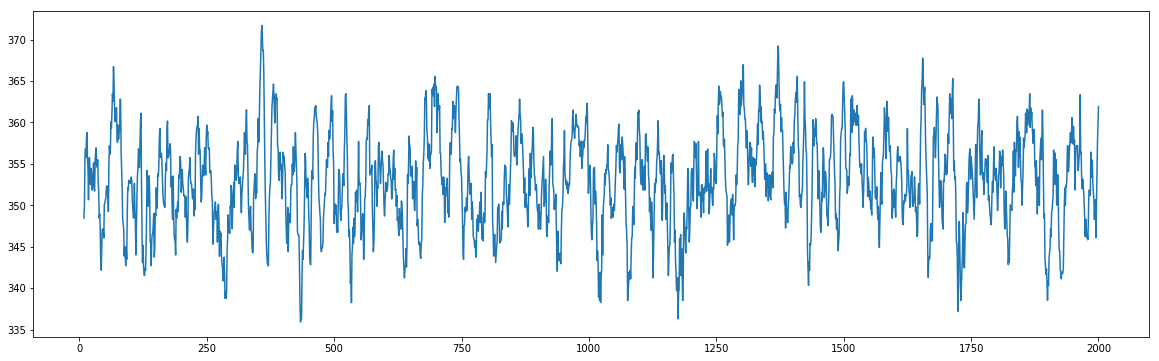

In [111]:
fig = plt.figure(figsize=(800, 6))
fig = plt.figure(figsize=(20, 6))
ax = plt.axes()

#x = np.linspace(0, 10, 1000)
ax.plot( pose_org.loc[0:2000, 'x_0'].rolling(window=10).mean() )
#ax.plot(testdfau['AU20_r'])


In [60]:
#posedf

pose_org_fp = pd.read_csv('./op_results/debate1_trump_keypoints_fixed.csv', chunksize=chunksize, iterator=True)

pose_org = pd.concat(pose_org_fp, ignore_index=True)
pose_org.columns = pose_org.columns.str.strip()
pose_org = pose_org.reset_index(drop=True)

pose_org
print(pose_org.mean())


print(pose_org.std())
pose_org

frame    71229.000000
x_0        352.812536
y_0        177.891543
x_1        343.708862
y_1        271.055205
x_2        225.339858
y_2        264.408060
x_3        173.574774
y_3        374.973162
x_4         19.585636
y_4         29.702669
x_5        462.089803
y_5        272.959465
x_6         10.789627
y_6          9.223702
x_7          0.249410
y_7          0.218968
x_8          0.000000
y_8          0.000000
x_9          0.000000
y_9          0.000000
x_10         0.000000
y_10         0.000000
x_11         0.000000
y_11         0.000000
x_12         0.000000
y_12         0.000000
x_13         0.000000
y_13         0.000000
x_14         0.000000
y_14         0.000000
x_15       328.568941
y_15       160.534376
x_16       367.519757
y_16       153.086614
x_17       295.894496
y_17       175.937682
x_18       371.521571
y_18       149.245809
x_19         0.000000
y_19         0.000000
x_20         0.000000
y_20         0.000000
x_21         0.000000
y_21         0.000000
x_22      

,frame,x_0,y_0,x_1,y_1,x_2,y_2,x_3,y_3,x_4,...,x_20,y_20,x_21,y_21,x_22,y_22,x_23,y_23,x_24,y_24
0,1,342.445,171.433,350.295,265.427,228.906,258.936,192.338,395.977,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,304.604,180.572,325.491,288.949,197.585,277.230,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,341.195,170.182,351.601,261.540,239.344,252.399,191.065,388.140,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,371.148,175.413,350.276,264.156,238.028,253.687,193.652,375.092,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,337.236,170.182,345.045,269.391,224.965,265.469,187.141,414.239,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,350.280,141.477,348.994,262.854,236.735,254.980,192.375,390.747,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,367.265,162.349,350.310,265.452,236.753,268.078,184.566,399.885,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,372.519,180.563,345.066,266.797,227.612,258.911,184.537,393.355,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,367.236,176.688,347.666,269.369,232.806,262.857,191.036,394.668,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,330.744,172.813,351.613,268.056,256.296,251.086,228.902,346.381,209.325,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [372]:
train_labels

,hc_lookat2,hc_brush1,hc_nvdis1,hc_look,hc_eyebrow,hc_atface,hc_feface,hc_hrface,hc_saface,hc_neuface,...,hc_affgest,hc_defgest,hc_agentic,hc_waveoff,hc_nvtic1,hc_nvtic2,hc_nvtic3,hc_nvtic5,hc_nvtic4,hc_interruptions
v1,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,1,1,0,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0
2,0,0,0,1,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,1,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
5,0,0,0,1,1,0,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0
6,0,0,0,1,1,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0
7,0,0,0,1,1,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0
8,0,0,0,1,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
9,0,0,0,1,1,0,0,0,0,1,...,1,0,1,1,0,0,0,0,0,0
